# Imports

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Got this idea from justin-hj-kim
# Use kmeans to create clusters that will represent districts, i'm going to use only lat/long data
# To train, i will use an 10% out-of-sample of training data, to avoid leak
df = pd.read_parquet('../data/train_test/full_valid.parquet.gzip')
print(df.shape)
df.head()

(174652, 14)


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,year_month_day,daily_preciptation_normal_inches,max_temperature_normal_f,min_temperature_normal_f,avg_temperature_normal_f
0,id1718206,1,2016-01-05 10:07:14,1,-73.990273,40.766647,-73.992729,40.748363,N,20160105,0.12,40,29,35
1,id1748564,2,2016-01-07 14:38:51,1,-73.976311,40.759819,-73.957603,40.779598,N,20160107,0.12,40,29,34
2,id3792886,1,2016-05-29 22:11:39,2,-74.006760,40.749096,-73.972206,40.757252,N,20160529,0.14,75,59,67
3,id2541269,2,2016-03-01 12:33:26,5,-73.982689,40.782124,-73.956490,40.781673,N,20160301,0.13,45,32,39
4,id3152266,2,2016-04-14 18:52:23,1,-73.802071,40.663708,-73.982391,40.766552,N,20160414,0.13,61,45,53


# Cluster Districts of NYC

## Kmeans

### Defining K

In [3]:
longitude = list(df['pickup_longitude']) + list(df['dropoff_longitude'])
latitude = list(df['pickup_latitude']) + list(df['dropoff_latitude'])

loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

loc_df = loc_df.astype(np.float32).values

In [12]:
inertia = []
silhouette_scores = []

for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=777)
    cluster_labels = kmeans.fit_predict(loc_df)
    inertia.append(kmeans.inertia_)
    
    silhouette_avg = silhouette_score(loc_df, cluster_labels, sample_size=30000, random_state=777)
    silhouette_scores.append(silhouette_avg)

    print(f"k = {k} | Inertia: {kmeans.inertia_:.2f} | Silhouette: {silhouette_avg:.4f}")

k = 2 | Inertia: 635.65 | Silhouette: 0.7937
k = 3 | Inertia: 432.05 | Silhouette: 0.4296
k = 4 | Inertia: 362.48 | Silhouette: 0.3970
k = 5 | Inertia: 299.83 | Silhouette: 0.4110
k = 6 | Inertia: 193.66 | Silhouette: 0.4111
k = 7 | Inertia: 172.77 | Silhouette: 0.3493
k = 8 | Inertia: 135.47 | Silhouette: 0.3557
k = 9 | Inertia: 120.34 | Silhouette: 0.3732
k = 10 | Inertia: 100.64 | Silhouette: 0.3638
k = 11 | Inertia: 92.54 | Silhouette: 0.3445
k = 12 | Inertia: 85.86 | Silhouette: 0.3478
k = 13 | Inertia: 75.38 | Silhouette: 0.3385
k = 14 | Inertia: 66.48 | Silhouette: 0.3799
k = 15 | Inertia: 62.48 | Silhouette: 0.3671
k = 16 | Inertia: 57.68 | Silhouette: 0.3807
k = 17 | Inertia: 55.39 | Silhouette: 0.3828
k = 18 | Inertia: 53.26 | Silhouette: 0.3856
k = 19 | Inertia: 48.68 | Silhouette: 0.3902
k = 20 | Inertia: 47.59 | Silhouette: 0.3903
k = 21 | Inertia: 41.17 | Silhouette: 0.3939
k = 22 | Inertia: 39.40 | Silhouette: 0.3940
k = 23 | Inertia: 36.94 | Silhouette: 0.3974
k = 24 | 

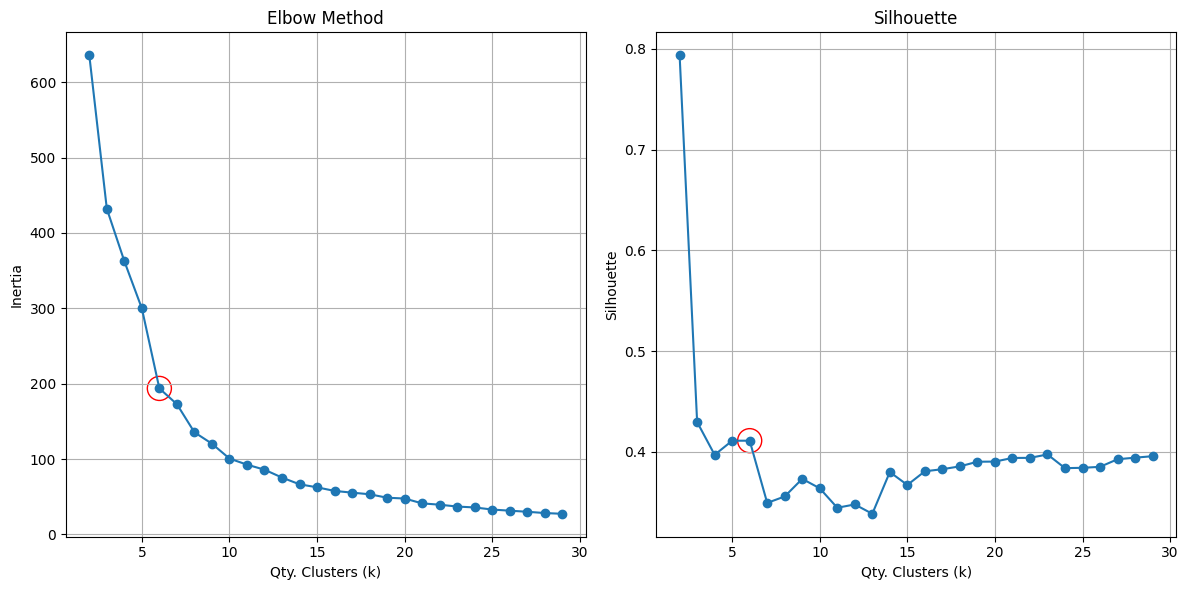

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(list(range(2, 30)), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Qty. Clusters (k)')
plt.ylabel('Inertia')
plt.grid()

x_highlight = 6
y_highlight = 193.66
plt.scatter(x_highlight, y_highlight, s=300, facecolors='none', edgecolors='r')

plt.subplot(1, 2, 2)
plt.plot(list(range(2, 30)), silhouette_scores, marker='o')
plt.title('Silhouette')
plt.xlabel('Qty. Clusters (k)')
plt.ylabel('Silhouette')
plt.grid()

x_highlight = 6
y_highlight = 0.4111
plt.scatter(x_highlight, y_highlight, s=300, facecolors='none', edgecolors='r')

plt.tight_layout()
plt.show()

In [ ]:
# I will choose k = 6 mainly because of the silhouette coefficient

### Creating Clusters

In [23]:
kmeans = KMeans(n_clusters=6, random_state=777, algorithm='lloyd').fit(loc_df)

In [24]:
df['pickup_cluster'] = kmeans.predict(df[['pickup_longitude','pickup_latitude']].values)
df['dropoff_cluster'] = kmeans.predict(df[['dropoff_longitude','dropoff_latitude']].values)

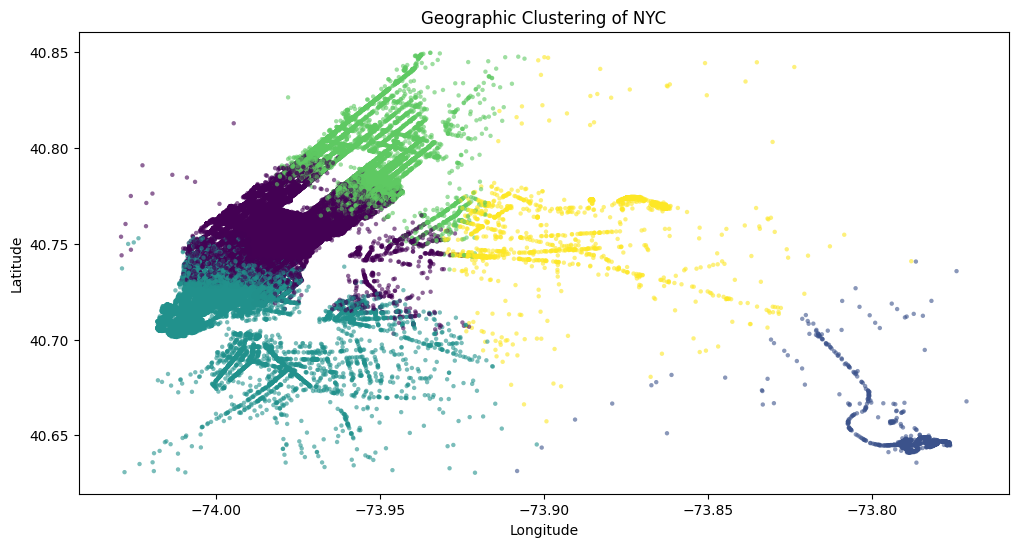

In [37]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,6))
ax.scatter(df['pickup_longitude'].values, 
           df['pickup_latitude'].values, s=10, lw=0,
           c=df['pickup_cluster'].values, alpha=0.6)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.gca()#.set_aspect('equal', adjustable='box')
plt.title('Geographic Clustering of NYC')
plt.show()

# Knowledge Base to split districts

# Condensing Analytical to Daily Features